In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, DataLoader


import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

PyTorch Version:  2.3.0+cu121
Torchvision Version:  0.18.0+cu121


## Load and view data

In [ ]:
# # Install Kaggle API
# !pip install kaggle

# # Download the dataset from Kaggle
# !kaggle datasets download -d landlord/handwriting-recognition

# # Create the target directory if it doesn't exist
# import os
# target_dir = 'handwriting-recognition'
# os.makedirs(target_dir, exist_ok=True)

# # Unzip the downloaded file into the target directory
# import zipfile
# with zipfile.ZipFile('handwriting-recognition.zip', 'r') as zip_ref:
#     zip_ref.extractall(target_dir)

# # Verify the files are in the correct directory
# import os
# print("Files in 'handwriting-recognition':", os.listdir(target_dir))

Dataset URL: https://www.kaggle.com/datasets/landlord/handwriting-recognition
License(s): CC0-1.0
 99% 1.24G/1.26G [00:13<00:00, 151MB/s]
100% 1.26G/1.26G [00:13<00:00, 96.9MB/s]
Files in 'handwriting-recognition': ['test_v2', 'written_name_train_v2.csv', 'written_name_test_v2.csv', 'train_v2', 'written_name_validation_v2.csv', 'validation_v2']


In [2]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid_letters/letter_3363.png  
  inflating: valid_letters/letter_33630.png  
  inflating: valid_letters/letter_33631.png  
  inflating: valid_letters/letter_33632.png  
  inflating: valid_letters/letter_33633.png  
  inflating: valid_letters/letter_33634.png  
  inflating: valid_letters/letter_33635.png  
  inflating: valid_letters/letter_33636.png  
  inflating: valid_letters/letter_33637.png  
  inflating: valid_letters/letter_33638.png  
  inflating: valid_letters/letter_33639.png  
  inflating: valid_letters/letter_3364.png  
  inflating: valid_letters/letter_33640.png  
  inflating: valid_letters/letter_33641.png  
  inflating: valid_letters/letter_33642.png  
  inflating: valid_letters/letter_33643.png  
  inflating: valid_letters/letter_33644.png  
  inflating: valid_letters/letter_33645.png  
  inflating: valid_letters/letter_33646.png  
  inflating: valid_letters/letter_33648.png  
  inflating: valid_letters/lett

In [3]:
# Preparar el dataset
features = pd.read_csv('written_letters_train.csv')
labels = pd.read_csv('written_letters_validation.csv')


Visualitzem les dades.

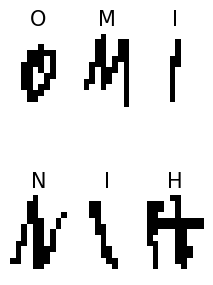

In [31]:
plt.figure(figsize=(2.5, 3.5))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_letters/'+features.loc[i, 'id']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(features.loc[i, 'nombre'], fontsize=15)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Cleaning Data

In [23]:
print("Number of NaNs in train set      : ", features['nombre'].isnull().sum())
print("Number of NaNs in validation set : ", labels['nombre'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [24]:
features.dropna(axis=0, inplace=True)
labels.dropna(axis=0, inplace=True)

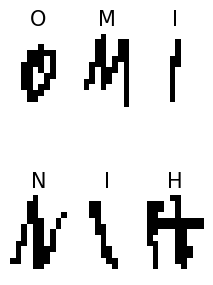

In [33]:
unreadable = features[features['nombre'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(2.5, 3.5))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_letters/'+features.loc[i, 'id']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(features.loc[i, 'nombre'], fontsize=15)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [34]:
features = features[features['nombre'] != 'UNREADABLE']
labels = labels[labels['nombre'] != 'UNREADABLE']

In [35]:
features['nombre'] = features['nombre'].str.upper()
labels['nombre'] = labels['nombre'].str.upper()

In [36]:
features.reset_index(inplace = True, drop=True)
labels.reset_index(inplace = True, drop=True)

## Preprocessing and preparing the images for training

In [ ]:
data_dir = "handwriting-recognition/"

In [ ]:
# ResNet input size
input_size = (224,224)

# Just normalization
data_transforms = {
    'train_v2': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation_v2': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
print("Initializing Datasets and Dataloaders...")

# Load the datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train_v2', 'validation_v2']}

In [ ]:
# Function to create a subset of the dataset
def get_subset(dataset, sample_size):
    indices = np.random.choice(len(dataset), size=sample_size, replace=False)
    return Subset(dataset, indices)

In [ ]:
train_v2_size = 30000
validation_v2_size = 3000

# Create subsets
train_subset = get_subset(image_datasets['train_v2'], train_v2_size)
validation_subset = get_subset(image_datasets['validation_v2'], validation_v2_size)

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train_v2', 'validation_v2']}
# Create training and validation dataloaders
dataloaders_dict = {
    'train_v2': DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4),
    'validation_v2': DataLoader(validation_subset, batch_size=batch_size, shuffle=False, num_workers=4),
}


Initializing Datasets and Dataloaders...


In [ ]:
# Function to count total samples in a DataLoader
def count_samples(dataloader):
    total_samples = 0
    for inputs, labels in dataloader:
        total_samples += len(inputs)
    return total_samples

# Check the size of the dataloaders
train_size = count_samples(dataloaders_dict['train_v2'])
validation_size = count_samples(dataloaders_dict['validation_v2'])

print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {validation_size}")

Training dataset size: 3000
Validation dataset size: 300


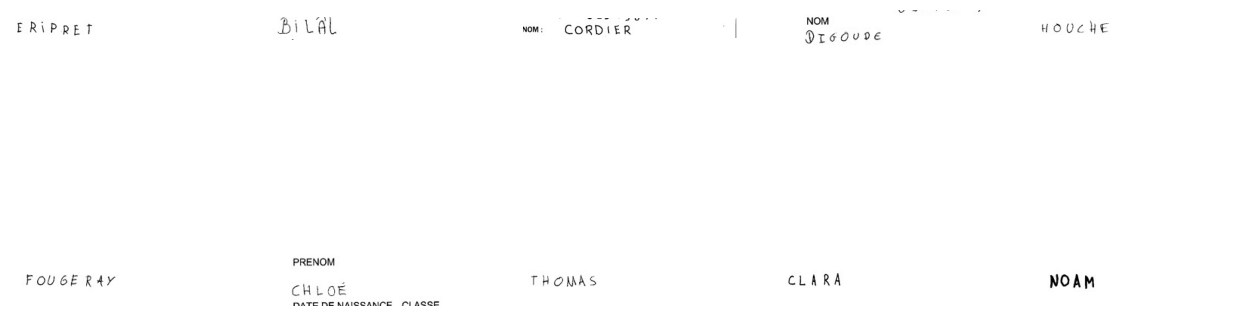

In [ ]:
import matplotlib.image as mpimg

# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    idx = np.random.randint(0,len(image_datasets['train_v2'].samples))
    image = mpimg.imread(image_datasets['train_v2'].samples[idx][0])
    plt.imshow(image)
    plt.axis('off');

## Training function

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train_v2": [], "validation_v2": []}
    losses = {"train_v2": [], "validation_v2": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train_v2', 'validation_v2']:
            if phase == 'train_v2':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train_v2'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    losses[phase].append(loss)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train_v2':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation_v2' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses

## Initialize model

In [ ]:
def initialize_model(num_classes):
    # Resnet18
    model = models.resnet18()

    model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True) # YOUR CODE HERE!

    input_size = 224

    return model, input_size

alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
# Number of classes in the dataset
num_classes = len(alphabets) + 1 # +1 for ctc pseudo blank

# Initialize the model
model, input_size = initialize_model(num_classes)

# Print the model we just instantiated
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Run Training and Validation

In [ ]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train fors
num_epochs = 15

optimizer_ft = optim.Adam(model.parameters(), lr=0.00001)

# Train and evaluate
model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/14
----------


KeyboardInterrupt: 

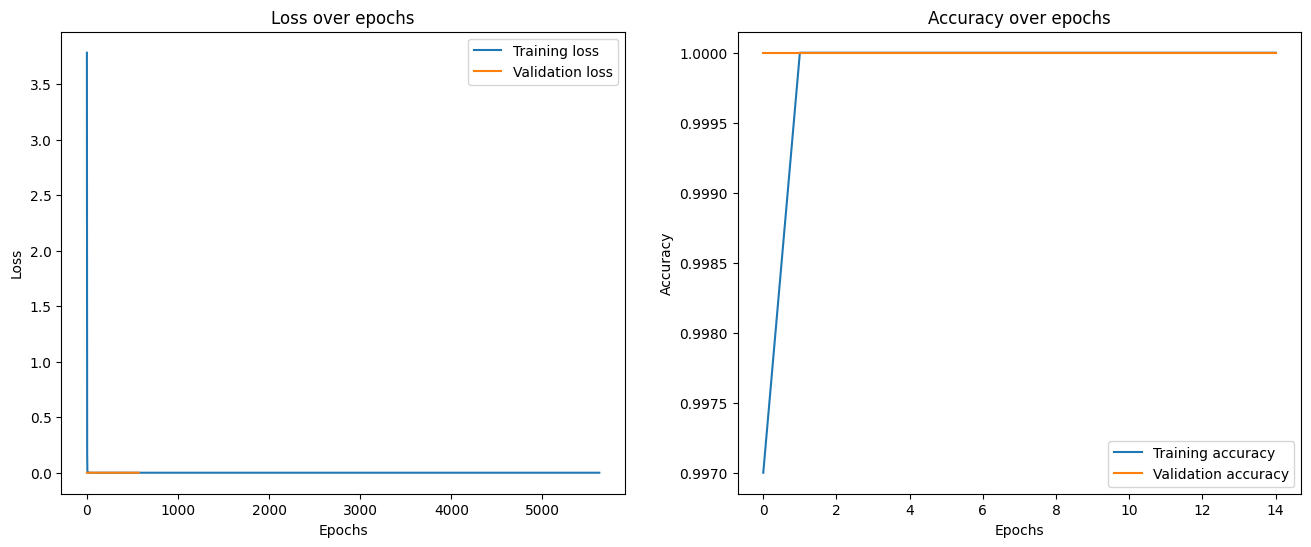

In [ ]:
# plot the losses and accuracies
train_losses = [loss.cpu().detach().numpy() for loss in losses["train_v2"]]
val_losses = [loss.cpu().detach().numpy() for loss in losses["validation_v2"]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the training and validation losses
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.set_title('Loss over epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the training and validation accuracies
ax2.plot([acc.cpu().detach().numpy() for acc in hist['train_v2']], label='Training accuracy')
ax2.plot([acc.cpu().detach().numpy() for acc in hist['validation_v2']], label='Validation accuracy')
ax2.set_title('Accuracy over epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
batch_images=np.ones((128,256,64,1),dtype=np.float32)
img=cv2.imread('handwriting-recognition/test_v2/test/TEST_34083.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img=cv2.resize(img,(256,64))
img=(img/255).astype(np.float32)
img=img.T
img=np.expand_dims(img,axis=-1)
batch_images[0]=img
x=model.predict(batch_images)
pred_texts = decode_batch_predictions(x)
pred_texts = pred_texts[0]
im=cv2.imread('test_v2/test/TEST_34083.jpg')
plt.imshow(img)
plt.imshow(im)
print('Predicted Text:',pred_texts)

AttributeError: 'ResNet' object has no attribute 'predict'